<a href="https://colab.research.google.com/github/suryamanikanta66/fmml-226Q1A4225/blob/main/FMML_Course_Topic_8_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 2 - Naive Bayes Classifiers

Lab by V Vijay Vignesh

vijay.vignesh@research.iiit.ac.in

In [3]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [4]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/symptoms-train.csv
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/symptoms-test.csv
plt.style.use('ggplot')

--2024-03-18 14:34:59--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/symptoms-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1370414 (1.3M) [text/plain]
Saving to: ‘symptoms-train.csv.1’

symptoms-train.csv. 100%[===================>]   1.31M  --.-KB/s    in 0.01s   

2024-03-18 14:34:59 (119 MB/s) - ‘symptoms-train.csv.1’ saved [1370414/1370414]

--2024-03-18 14:34:59--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/symptoms-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

## Priors Applied to Classification

We have seen how our belief on real valued problems (regression tasks) changes with the prior. However, priors are also very important in classification tasks.

Typically, when we have data belonging to two classes, and both classes are identical with different means, we draw the decision boundary between them (shown in the figure by the black line). This again

### Different Priors, Different Decision Boundaries

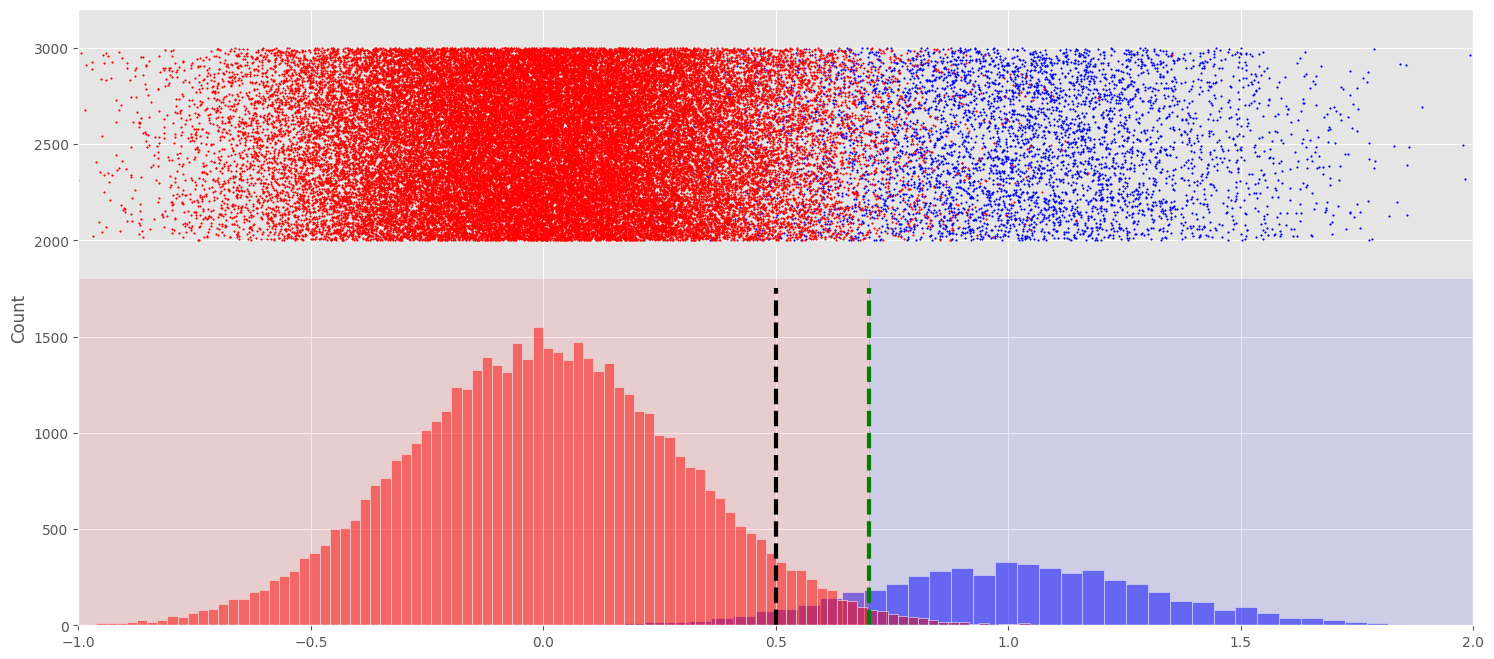

In [5]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

Prior information can be more complex. If the probability of both the classes is the same, but one has **higher variance** than the other (more spread out), then the decision boundary can again get skewed.

An example of this behavior is shown below.

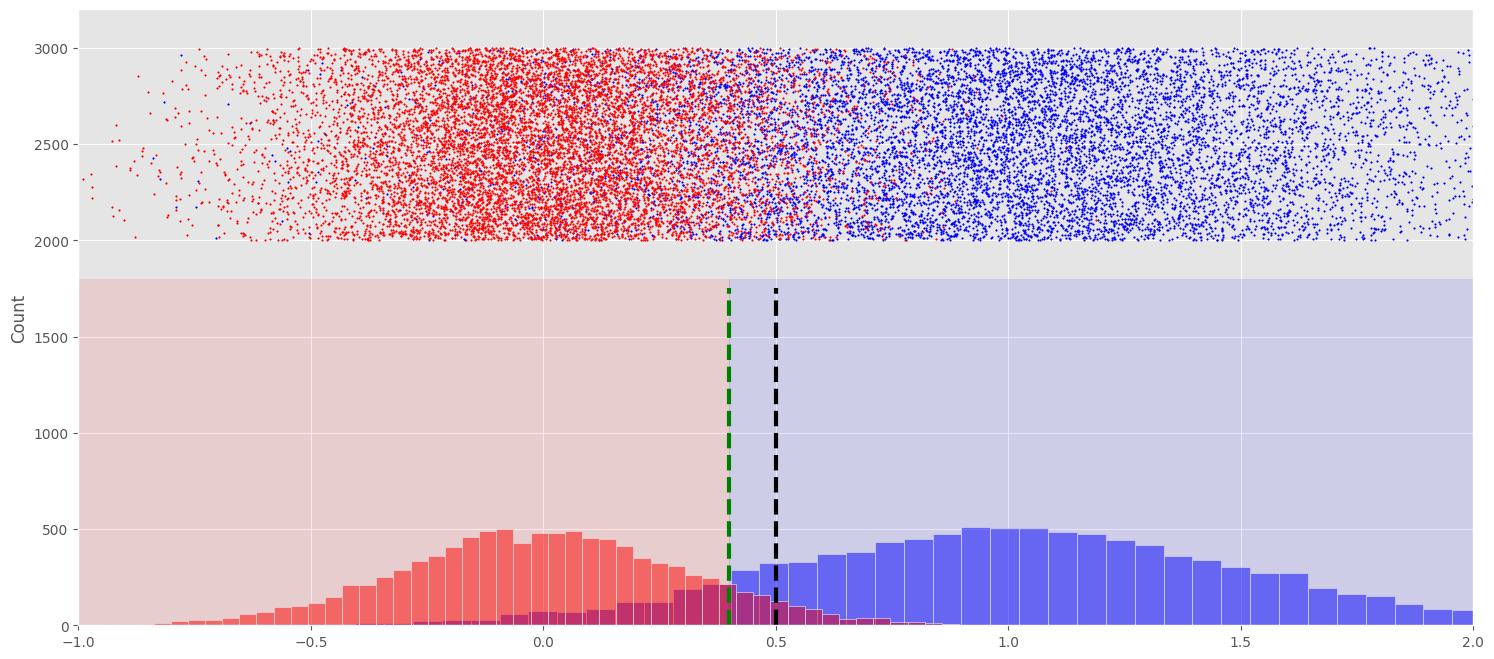

In [6]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.5, size=10000)
x2 = np.random.normal(0.0, 0.3, size=10000)
x = np.concatenate([x1, x2])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.4, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.4, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.4, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

### When Priors force you to change your model

Finally, Prior understanding can change your model in totality. If the variances are very different, it's possible that a single split may not suffice.

This is a **Callback to Decision Trees** where a single real valued parameter may end up in **multiple splits**. Below is an example of when this might be necessary.

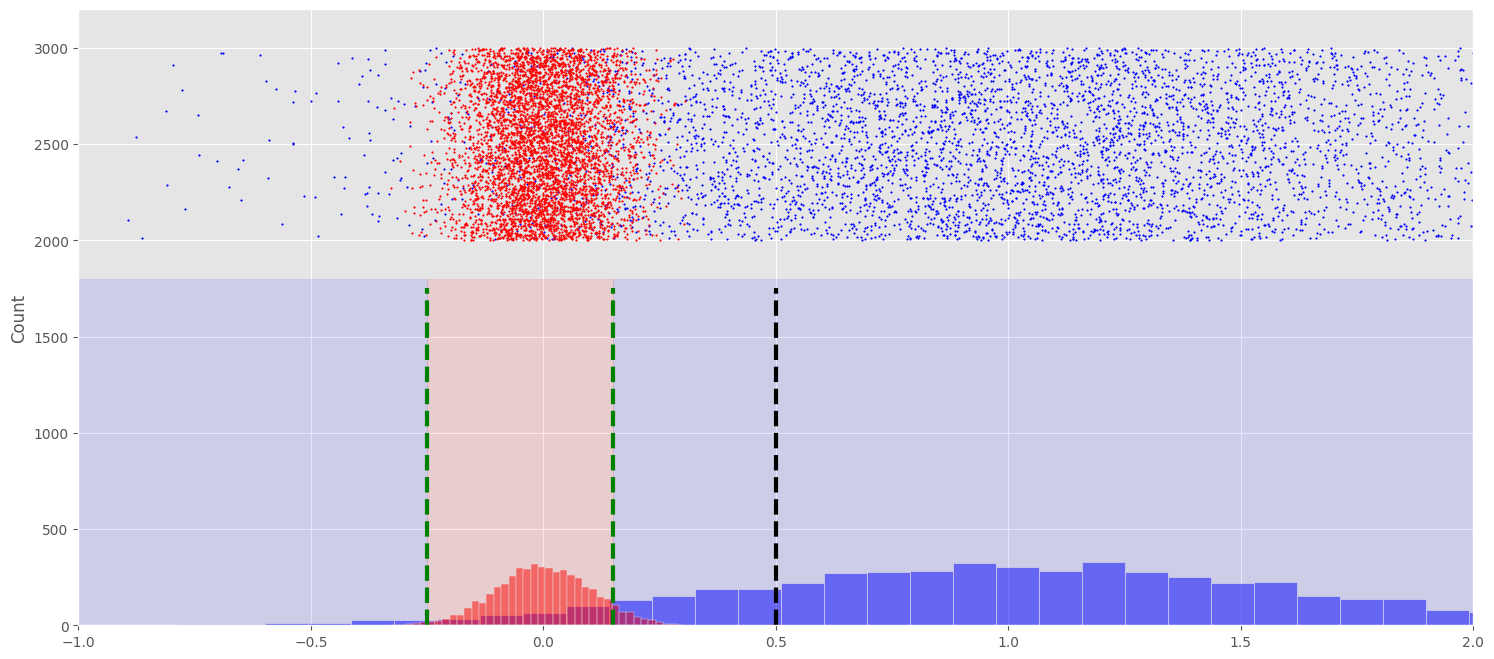

In [7]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.6, size=5000)
x2 = np.random.normal(0.0, 0.1, size=5000)
x = np.concatenate([x1, x2])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, -0.25, 100), 0, 1800,  color='b', alpha=0.1)
ax.fill_between(np.linspace(-0.25, 0.15, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.15, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.15, 0, 1750, color="g", linestyles="--", lw=3)
ax.vlines(-0.25, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

## Application to HealthCare: Predicting Diseases from Symptoms

### Data you learn at School

Let's take a look at the Diseases and their Symptoms dataset. This dataset is downloaded from [Kaggle](https://kaggle.com/datasets).

We will start by reading the CSV file, processing it, analyzing and plotting the grid of diseases and their symptoms. We also perform some data preprocessing, converting the table to patients into a grid of counts, dropping a column, clustering rows, etc. All of this manipulation is done in Pandas.

In [8]:
patients_df = pd.read_csv("symptoms-train.csv")
patients_df[np.concatenate([np.random.choice(list(patients_df.columns), 6, replace=False), ["prognosis"]])].sample(10)

,mood_swings,mucoid_sputum,congestion,constipation,hip_joint_pain,spinning_movements,prognosis
1942,0,0,0,0,0,0,Varicose veins
3850,0,0,0,0,0,0,Acne
444,0,0,0,0,0,0,Chronic cholestasis
3927,1,0,0,0,0,0,Hyperthyroidism
3717,0,0,0,0,0,0,Pneumonia
661,0,0,0,0,0,0,Tuberculosis
3038,0,0,0,0,0,0,Drug Reaction
3821,0,0,0,0,0,0,Gastroenteritis
3190,0,0,0,0,0,0,Hypoglycemia
3098,0,0,0,0,0,0,Hepatitis E


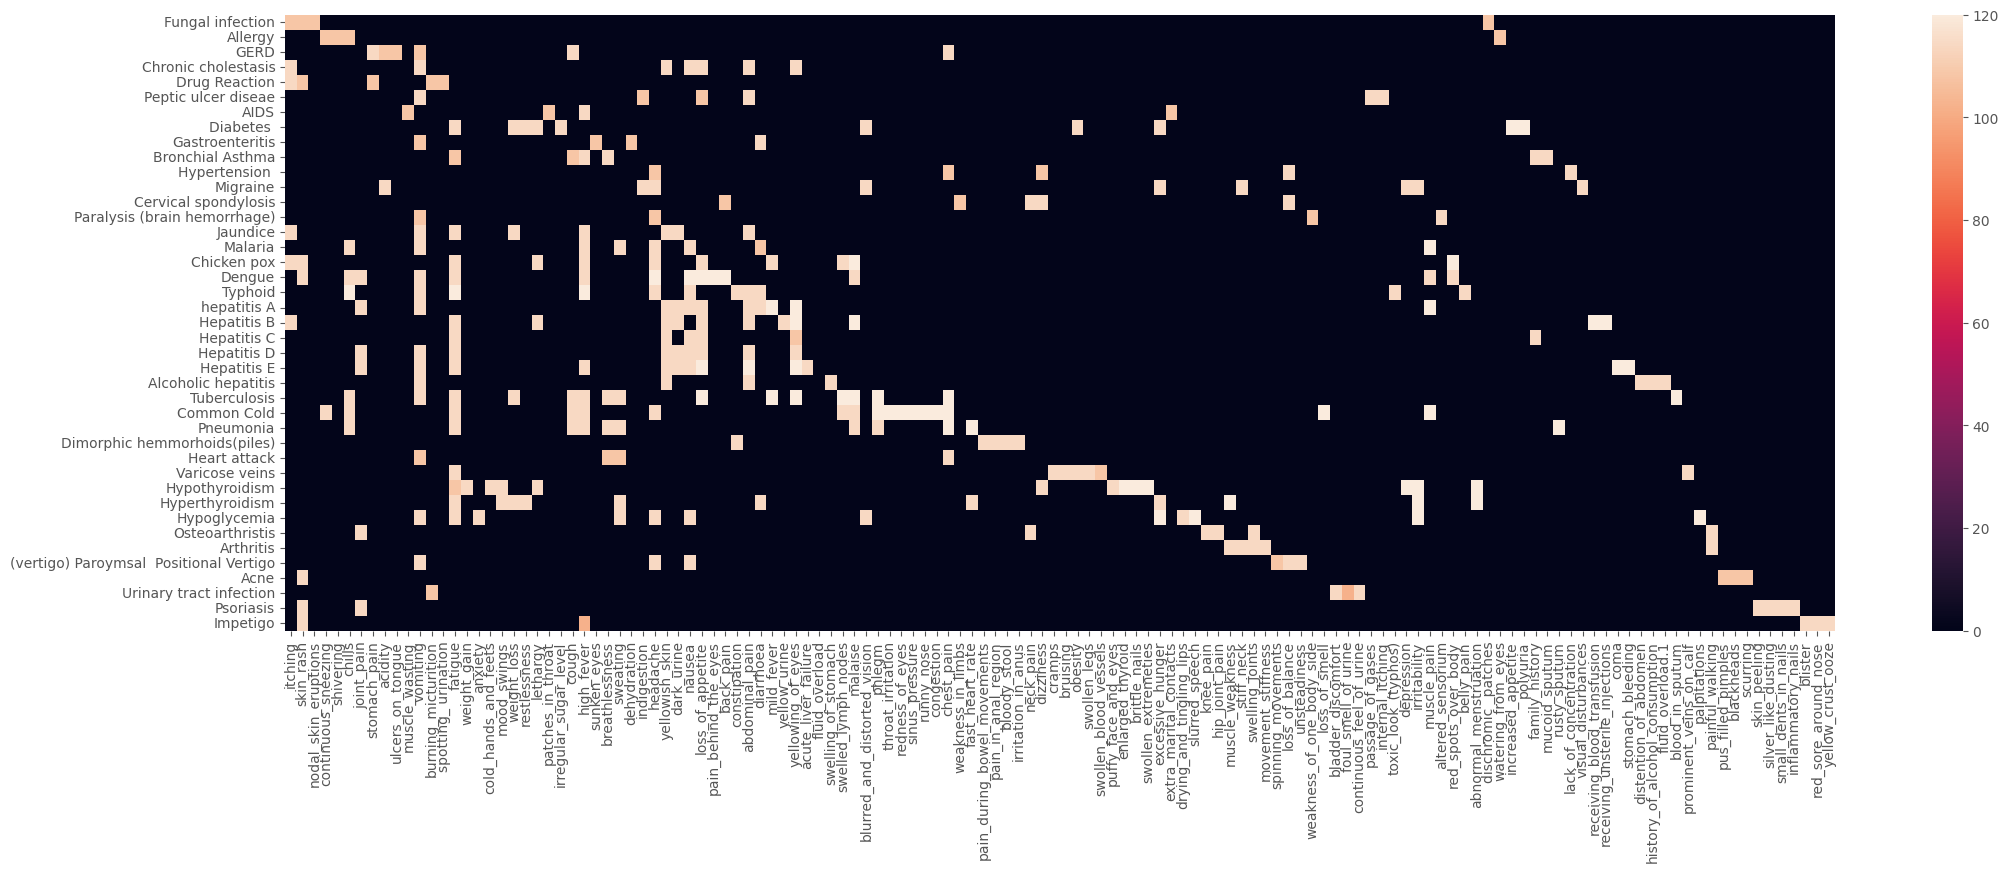

In [9]:
diseases = patients_df["prognosis"].unique()
symptoms = patients_df.drop(["prognosis"], axis=1).columns.values
counts = np.zeros((len(diseases), len(symptoms)))
disease_counts = dict()
for disease_id, disease in enumerate(diseases):
    sub_df = patients_df.loc[patients_df["prognosis"] == disease]
    for symptom_id, symptom in enumerate(symptoms):
        counts[disease_id][symptom_id] = np.sum(sub_df[symptom] == 1)
    disease_counts[disease] = np.sum(counts[disease_id])
plt.figure(figsize=(25, 8))
sns.heatmap(counts, xticklabels=symptoms, yticklabels=diseases)
plt.show()

### Looking at the Marginal Distributions

In [10]:
fig = pg.Figure([pg.Bar(x=diseases, y=np.sum(counts, axis=1))])
fig.update_layout(title_text='Diseases Probaility Histogram (Prior)', xaxis={'title': 'Disease'}, yaxis={'title': 'Count'})
fig.show()
fig = pg.Figure([pg.Bar(x=symptoms, y=np.sum(counts, axis=0))])
fig.update_layout(title_text='Symptoms Probaility Histogram (Likelihood)', xaxis={'title': 'Symptom'}, yaxis={'title': 'Count'})
fig.show()

### Symptom Level Research, the Online Lookup

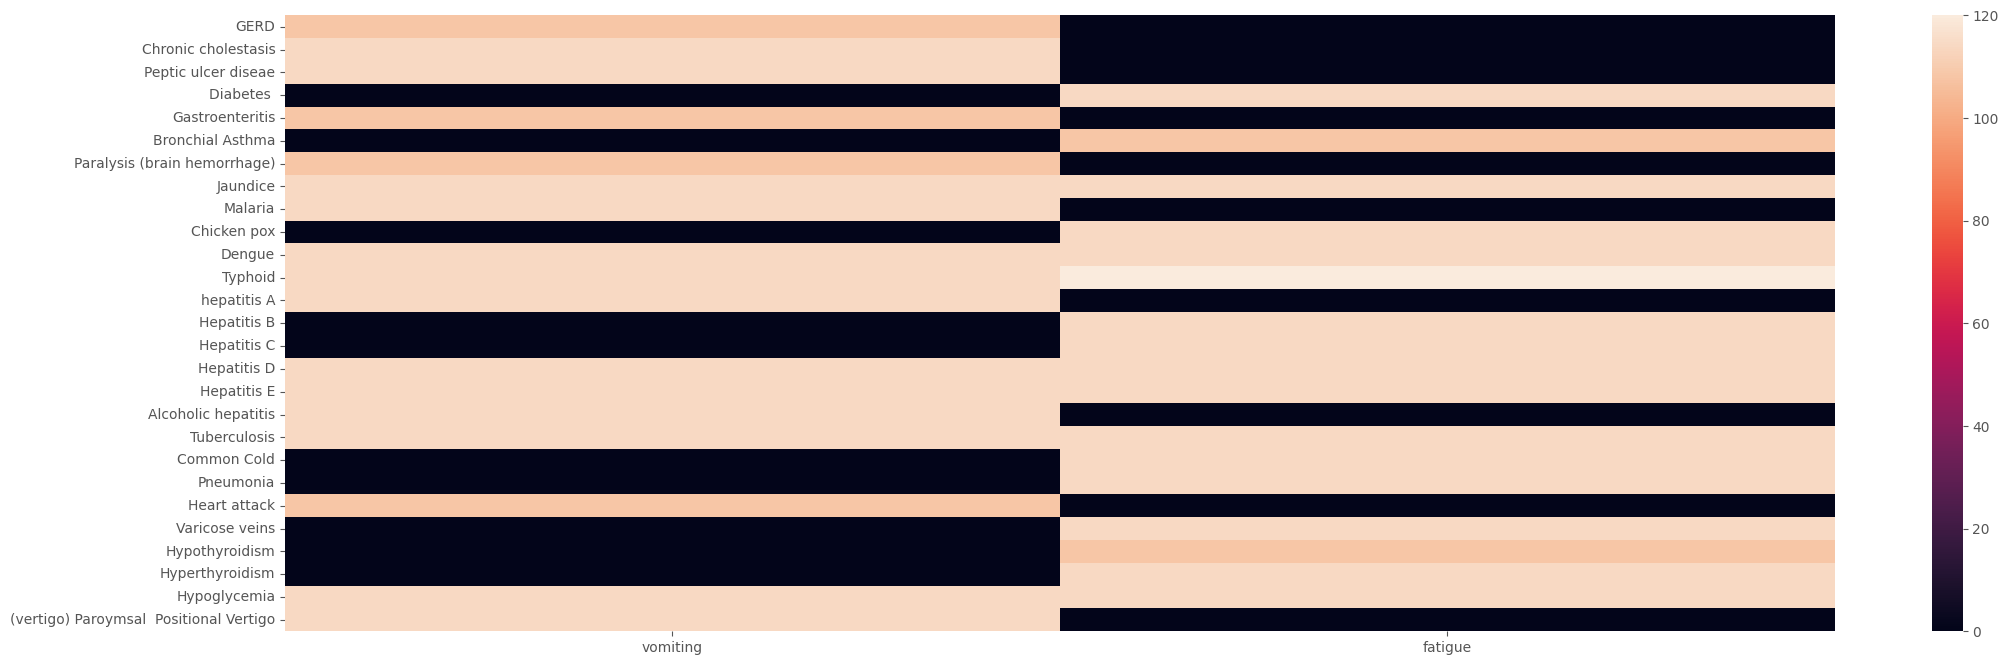

In [11]:
symptoms = ["vomiting", "fatigue"]
filtered_df = patients_df[symptoms + ["prognosis"]].loc[(np.logical_or(*[patients_df[symptom] == 1 for symptom in symptoms]))]

diseases = filtered_df["prognosis"].unique()
symptoms = filtered_df.drop(["prognosis"], axis=1).columns.values
filtered_counts = np.zeros((len(diseases), len(symptoms)))
disease_priors = np.zeros(len(diseases))
for disease_id, disease in enumerate(diseases):
    sub_df = filtered_df.loc[filtered_df["prognosis"] == disease]
    disease_priors[disease_id] = disease_counts[disease]
    for symptom_id, symptom in enumerate(symptoms):
        filtered_counts[disease_id][symptom_id] = np.sum(sub_df[symptom] == 1)
plt.figure(figsize=(25, 8))
sns.heatmap(filtered_counts, xticklabels=symptoms, yticklabels=diseases)
plt.show()
disease_priors = disease_priors / np.sum(disease_priors)

Let's take a model of summing up probabilities, i.e. Probability due to both causes is the total number of people who had the Diseases with either of the two symptoms.

Let's compute this distribution in a more understandable form, as the total probability.

In [12]:
evidence = np.sum(filtered_counts / np.sum(filtered_counts, axis=0), axis=1) / 2

fig = pg.Figure(data=[
    pg.Bar(name='Evidence', x=diseases, y=evidence),
])
# Change the bar mode
fig.show()

By looking at the symptoms (Googling them per say), we get this list of probabilities. You are already familiar that all queries about symptoms on Google lead you to cancer. Well here, they lead you to Dengue, Typhoid, and even Hypoglycemia, because these match the symptoms the best.

But are these really the top diseases that a doctor will predict. **Is there really Dengue in your city, could it be that you are the only one who got it?**

### How Good Doctors think - A Bayesian perspective

Again, let's use our Textbook knowledge of diseases and symptom probabilities as our Prior model, and what have just Googled as the posterior, and make a disease prediction model.

In [13]:
evidence = np.sum(filtered_counts / np.sum(filtered_counts, axis=0), axis=1) / 2
posterior = (evidence * disease_priors) / np.sum(evidence * disease_priors)

fig = pg.Figure(data=[
    pg.Bar(name='Evidence', x=diseases, y=evidence),
    pg.Bar(name='Prior', x=diseases, y=disease_priors),
    pg.Bar(name='Posterior', x=diseases, y=posterior)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

Incorporating all the data we have, we understand that Tuberculosis is indeed the most probable disease, it's both a common disease and matches your symptoms.

Very few people suffer from Hypoglycemia, it'snot a relevant disease to consider. Common cold is a very common disease, but it doesn't match symptoms well enough.

## The Take Home Lesson

We just noticed how good doctors think, incorporating all the Prior knowledge and the new found Evidence, computing good Joint probability distributions, etc. We need to do the same for our ML models.

Designing effective probabilistically correct models is very difficult but exteremely crucial to make understandable AI. It's of fundamental importance when we are dealing with small data.

For large data, while probabilistically correct models are challenging, they are a major research topic, even if we can get this partially and obtain some explainability.

Suppose you want to make a vision model to implement Animal control in your college. There are jungles around so you want your models to be aware of all species. Your model needs to generate a warning if you see a dangerous animals. However, if features like Whiskers, etc. are spotted, you need to incorporate the idea that seeing a Lion is much less probable than seeing a similar looking cat, and have a more reasonable classifier. This sort of feature extraction and probabilistic reasoning with an ensemble of classifiers is partially Bayesian, and holds great promise in both research and industry.

For more visual stuff, you can take a look at these videos:
* [3Blue1Brown: Bayes Rule](https://youtu.be/HZGCoVF3YvM)
* [3Blue1Brown: The Proof of Bayes Rule](https://youtu.be/U_85TaXbeIo)
* [3Blue1Brown: Bayes Rule is Nicer with odds | Medical Diagnostic](https://youtu.be/lG4VkPoG3ko)
* [3Blue1Brown: Binomial distributions | Probabilities of probabilities](https://youtu.be/8idr1WZ1A7Q)
* [Veritasium: They Bayesian Trap](https://youtu.be/R13BD8qKeTg)

That was all in Lab 2. Have fun, Happy learning 😊!